In [1]:
#importing all packages
import matplotlib.pyplot as plt
import numpy as np
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.7.1


In [2]:
#Loading training and testing data as .npy files#Datasets are here in'.npy'format after being scaled individually based on their 
#individual maximum amplitude

def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample


train_set = torchvision.datasets.DatasetFolder(root='./data/wholedata/without_noise/ring_noring/train_set/',
                                               loader=npy_loader, 
                                               extensions='.npy', transform=None)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=10,
                                         shuffle=True, num_workers=2)

test_set = torchvision.datasets.DatasetFolder(root='./data/wholedata/without_noise/ring_noring/test_set/',
                                              loader=npy_loader, 
                                               extensions='.npy', transform=None)

testloader = torch.utils.data.DataLoader(test_set, batch_size=1,
                                         shuffle=False, num_workers=2)

classes = ('no-ring', 'ring')
print(classes)
print(len(train_set))
print(len(test_set))

('no-ring', 'ring')
2220
7234


torch.Size([10, 52, 52])
torch.Size([52, 52])
1.0


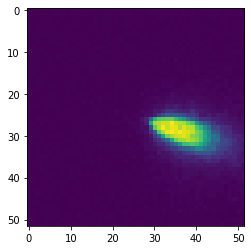

no-ring


In [3]:
##functions to show an image
def imshow(img):
    npimg = img.numpy()
    print(img.size())
    print(img[0].size())
    plt.imshow(npimg[0])
    print(np.max(npimg))
    plt.show()


##get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

##show images
imshow(torchvision.utils.make_grid(images))

##print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [4]:
##crosschecking the size using the chosen dimensions before defining the convolutional 
#layers:#Use the equation ((W-F+2P)S)+1 check if the size of the output layesrs are correct!
#images=images.view(-1,1,52,52)
#print(images.shape)
#conv1=nn.Conv2d(1,20,5)
#pool=nn.MaxPool2d(2,2)
#conv2=nn.Conv2d(20,4,3)
#x=conv1(images)
#print(x.shape)
#x=pool(x)
#print(x.shape)
#x=conv2(x)
#print(x.shape)
#x=pool(x)
#print(x.shape)

In [33]:
#crosschecking the size using the chosen dimensions before defining the convolutional 
#layers:#Use the equation ((W-F+2P)S)+1 check if the size of the output layesrs are correct!
images=images.view(-1,1,52,52)
print(images.shape)
conv1=nn.Conv2d(1,20,5)
pool=nn.AvgPool2d(2,2)
conv2=nn.Conv2d(20,4,3)
x=conv1(images)
print(x.shape)
x=pool(x)
print(x.shape)
x=conv2(x)
print(x.shape)
x=pool(x)
print(x.shape)

torch.Size([10, 1, 52, 52])
torch.Size([10, 20, 48, 48])
torch.Size([10, 20, 24, 24])
torch.Size([10, 4, 22, 22])
torch.Size([10, 4, 11, 11])


In [34]:
##Define a Convolutional Neural Network(For  1-channel images)

#class Net_ring_wholedata(nn.Module):
#    def __init__(self):
#        super(Net_ring_wholedata,self).__init__()
#        self.conv1=nn.Conv2d(1,20,5)
#        self.pool=nn.MaxPool2d(2,2)
#        self.conv2=nn.Conv2d(20,4,3)
#        self.fc1=nn.Linear(4*11*11,80)
#        self.fc2=nn.Linear(80,1)
        
        # Define proportion or neurons to dropout
        #self.dropout = nn.Dropout(0.1)
        
#    def forward(self, x):
#        x=x.view(-1,1,52,52)
        
#        # Apply dropout
#        #x = self.dropout(x)
        
#        x=self.pool(F.relu(self.conv1(x)))
#        x=self.pool(F.relu(self.conv2(x)))
#        x=x.view(-1,4*11*11)
#        x=F.relu(self.fc1(x))
#        x=self.fc2(x)
#        return x
#net=Net_ring_wholedata()

In [35]:
#Define a Convolutional Neural Network(For  1-channel images)

class Net_ring_wholedata(nn.Module):
    def __init__(self):
        super(Net_ring_wholedata,self).__init__()
        self.conv1=nn.Conv2d(1,20,5)
        self.pool=nn.AvgPool2d(2,2)
        self.conv2=nn.Conv2d(20,4,3)
        self.fc1=nn.Linear(4*11*11,80)
        self.fc2=nn.Linear(80,1)
        
        # Define proportion or neurons to dropout
        #self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        x=x.view(-1,1,52,52)
        
        # Apply dropout
        #x = self.dropout(x)
        
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,4*11*11)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x
net=Net_ring_wholedata()

In [36]:
##Define a Loss function and optimizer:#Loss function:Binary Cross-Entropy loss,
##optimizer: Adam#BCE_loss function needs the usage of Sigmoid activation function to be given for the
##binary classification

m = nn.Sigmoid()
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [37]:
##Train the network
# loop over our data iterator, and feed the inputs to the network and optimize

for epoch in range(100):# loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #print(labels)
        labels = torch.tensor(labels, dtype = torch.float)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        #print(outputs.shape)
        
        #use the sigmoid function(m) before calculation the gradient of loss function
        loss = criterion(m(outputs.squeeze()), labels)
        loss.backward()
        optimizer.step()
        
        # print statistics:
        # print every 10 mini-batches
        running_loss += loss.item()
        outputs = (outputs.squeeze()>0.5).float()
        correct += (outputs == labels).float().sum()
        if i % 10 == 9:                                                           
            print('[%d,%5d] loss:%.3f'% (epoch+1, i+1, running_loss/10))
            running_loss=0.0
    accuracy = 100*correct/(len(inputs)*len(trainloader))
    print('[Epoch: %d], loss:%.3f, Acc.:%.2f'% (epoch+1, running_loss/15, accuracy))
            
print('Finished Training')
        

/tmp/ipykernel_184315/1701007478.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype = torch.float)


[1,   10] loss:0.690
[1,   20] loss:0.703
[1,   30] loss:0.693
[1,   40] loss:0.694
[1,   50] loss:0.692
[1,   60] loss:0.690
[1,   70] loss:0.685
[1,   80] loss:0.682
[1,   90] loss:0.668
[1,  100] loss:0.679
[1,  110] loss:0.689
[1,  120] loss:0.669
[1,  130] loss:0.640
[1,  140] loss:0.656
[1,  150] loss:0.584
[1,  160] loss:0.677
[1,  170] loss:0.768
[1,  180] loss:0.678
[1,  190] loss:0.680
[1,  200] loss:0.677
[1,  210] loss:0.685
[1,  220] loss:0.660
[Epoch: 1], loss:0.092, Acc.:51.53
[2,   10] loss:0.620
[2,   20] loss:0.648
[2,   30] loss:0.633
[2,   40] loss:0.641
[2,   50] loss:0.650
[2,   60] loss:0.653
[2,   70] loss:0.612
[2,   80] loss:0.640
[2,   90] loss:0.639
[2,  100] loss:0.594
[2,  110] loss:0.564
[2,  120] loss:0.571
[2,  130] loss:0.568
[2,  140] loss:0.576
[2,  150] loss:0.635
[2,  160] loss:0.546
[2,  170] loss:0.560
[2,  180] loss:0.611
[2,  190] loss:0.543
[2,  200] loss:0.544
[2,  210] loss:0.567
[2,  220] loss:0.577
[Epoch: 2], loss:0.063, Acc.:63.56
[3,   

[17,   50] loss:0.200
[17,   60] loss:0.189
[17,   70] loss:0.283
[17,   80] loss:0.243
[17,   90] loss:0.264
[17,  100] loss:0.179
[17,  110] loss:0.260
[17,  120] loss:0.203
[17,  130] loss:0.238
[17,  140] loss:0.189
[17,  150] loss:0.216
[17,  160] loss:0.192
[17,  170] loss:0.277
[17,  180] loss:0.244
[17,  190] loss:0.153
[17,  200] loss:0.256
[17,  210] loss:0.271
[17,  220] loss:0.290
[Epoch: 17], loss:0.035, Acc.:89.55
[18,   10] loss:0.223
[18,   20] loss:0.229
[18,   30] loss:0.246
[18,   40] loss:0.233
[18,   50] loss:0.197
[18,   60] loss:0.265
[18,   70] loss:0.318
[18,   80] loss:0.206
[18,   90] loss:0.139
[18,  100] loss:0.160
[18,  110] loss:0.289
[18,  120] loss:0.183
[18,  130] loss:0.233
[18,  140] loss:0.476
[18,  150] loss:0.227
[18,  160] loss:0.205
[18,  170] loss:0.168
[18,  180] loss:0.259
[18,  190] loss:0.147
[18,  200] loss:0.219
[18,  210] loss:0.167
[18,  220] loss:0.240
[Epoch: 18], loss:0.016, Acc.:89.59
[19,   10] loss:0.201
[19,   20] loss:0.209
[19,

[33,   10] loss:0.096
[33,   20] loss:0.040
[33,   30] loss:0.094
[33,   40] loss:0.085
[33,   50] loss:0.099
[33,   60] loss:0.117
[33,   70] loss:0.097
[33,   80] loss:0.091
[33,   90] loss:0.090
[33,  100] loss:0.074
[33,  110] loss:0.055
[33,  120] loss:0.130
[33,  130] loss:0.074
[33,  140] loss:0.137
[33,  150] loss:0.065
[33,  160] loss:0.065
[33,  170] loss:0.106
[33,  180] loss:0.177
[33,  190] loss:0.230
[33,  200] loss:0.107
[33,  210] loss:0.089
[33,  220] loss:0.095
[Epoch: 33], loss:0.004, Acc.:95.90
[34,   10] loss:0.064
[34,   20] loss:0.132
[34,   30] loss:0.094
[34,   40] loss:0.175
[34,   50] loss:0.208
[34,   60] loss:0.067
[34,   70] loss:0.158
[34,   80] loss:0.095
[34,   90] loss:0.061
[34,  100] loss:0.035
[34,  110] loss:0.054
[34,  120] loss:0.074
[34,  130] loss:0.149
[34,  140] loss:0.083
[34,  150] loss:0.077
[34,  160] loss:0.067
[34,  170] loss:0.111
[34,  180] loss:0.109
[34,  190] loss:0.256
[34,  200] loss:0.217
[34,  210] loss:0.174
[34,  220] loss:0.

[48,  190] loss:0.106
[48,  200] loss:0.054
[48,  210] loss:0.091
[48,  220] loss:0.027
[Epoch: 48], loss:0.008, Acc.:96.58
[49,   10] loss:0.057
[49,   20] loss:0.108
[49,   30] loss:0.109
[49,   40] loss:0.097
[49,   50] loss:0.040
[49,   60] loss:0.035
[49,   70] loss:0.078
[49,   80] loss:0.052
[49,   90] loss:0.066
[49,  100] loss:0.026
[49,  110] loss:0.084
[49,  120] loss:0.085
[49,  130] loss:0.119
[49,  140] loss:0.248
[49,  150] loss:0.065
[49,  160] loss:0.118
[49,  170] loss:0.024
[49,  180] loss:0.044
[49,  190] loss:0.039
[49,  200] loss:0.057
[49,  210] loss:0.066
[49,  220] loss:0.081
[Epoch: 49], loss:0.006, Acc.:96.71
[50,   10] loss:0.106
[50,   20] loss:0.071
[50,   30] loss:0.041
[50,   40] loss:0.080
[50,   50] loss:0.096
[50,   60] loss:0.099
[50,   70] loss:0.125
[50,   80] loss:0.139
[50,   90] loss:0.101
[50,  100] loss:0.054
[50,  110] loss:0.027
[50,  120] loss:0.099
[50,  130] loss:0.081
[50,  140] loss:0.067
[50,  150] loss:0.039
[50,  160] loss:0.052
[50,

[64,  140] loss:0.043
[64,  150] loss:0.098
[64,  160] loss:0.043
[64,  170] loss:0.107
[64,  180] loss:0.186
[64,  190] loss:0.177
[64,  200] loss:0.099
[64,  210] loss:0.078
[64,  220] loss:0.100
[Epoch: 64], loss:0.013, Acc.:95.63
[65,   10] loss:0.051
[65,   20] loss:0.031
[65,   30] loss:0.067
[65,   40] loss:0.059
[65,   50] loss:0.079
[65,   60] loss:0.092
[65,   70] loss:0.087
[65,   80] loss:0.071
[65,   90] loss:0.036
[65,  100] loss:0.049
[65,  110] loss:0.033
[65,  120] loss:0.025
[65,  130] loss:0.058
[65,  140] loss:0.020
[65,  150] loss:0.048
[65,  160] loss:0.049
[65,  170] loss:0.031
[65,  180] loss:0.022
[65,  190] loss:0.028
[65,  200] loss:0.050
[65,  210] loss:0.050
[65,  220] loss:0.029
[Epoch: 65], loss:0.002, Acc.:98.20
[66,   10] loss:0.037
[66,   20] loss:0.033
[66,   30] loss:0.098
[66,   40] loss:0.053
[66,   50] loss:0.103
[66,   60] loss:0.089
[66,   70] loss:0.128
[66,   80] loss:0.326
[66,   90] loss:0.053
[66,  100] loss:0.113
[66,  110] loss:0.058
[66,

[80,   90] loss:0.118
[80,  100] loss:0.133
[80,  110] loss:0.191
[80,  120] loss:0.159
[80,  130] loss:0.035
[80,  140] loss:0.052
[80,  150] loss:0.039
[80,  160] loss:0.076
[80,  170] loss:0.027
[80,  180] loss:0.067
[80,  190] loss:0.045
[80,  200] loss:0.093
[80,  210] loss:0.088
[80,  220] loss:0.061
[Epoch: 80], loss:0.018, Acc.:96.71
[81,   10] loss:0.055
[81,   20] loss:0.070
[81,   30] loss:0.098
[81,   40] loss:0.073
[81,   50] loss:0.034
[81,   60] loss:0.052
[81,   70] loss:0.054
[81,   80] loss:0.086
[81,   90] loss:0.051
[81,  100] loss:0.180
[81,  110] loss:0.060
[81,  120] loss:0.049
[81,  130] loss:0.042
[81,  140] loss:0.097
[81,  150] loss:0.105
[81,  160] loss:0.076
[81,  170] loss:0.036
[81,  180] loss:0.044
[81,  190] loss:0.022
[81,  200] loss:0.046
[81,  210] loss:0.031
[81,  220] loss:0.046
[Epoch: 81], loss:0.007, Acc.:97.52
[82,   10] loss:0.125
[82,   20] loss:0.160
[82,   30] loss:0.030
[82,   40] loss:0.037
[82,   50] loss:0.025
[82,   60] loss:0.051
[82,

[96,   40] loss:0.058
[96,   50] loss:0.016
[96,   60] loss:0.024
[96,   70] loss:0.018
[96,   80] loss:0.046
[96,   90] loss:0.017
[96,  100] loss:0.021
[96,  110] loss:0.011
[96,  120] loss:0.008
[96,  130] loss:0.003
[96,  140] loss:0.019
[96,  150] loss:0.009
[96,  160] loss:0.008
[96,  170] loss:0.013
[96,  180] loss:0.008
[96,  190] loss:0.035
[96,  200] loss:0.052
[96,  210] loss:0.016
[96,  220] loss:0.031
[Epoch: 96], loss:0.009, Acc.:99.10
[97,   10] loss:0.065
[97,   20] loss:0.029
[97,   30] loss:0.032
[97,   40] loss:0.044
[97,   50] loss:0.085
[97,   60] loss:0.106
[97,   70] loss:0.012
[97,   80] loss:0.089
[97,   90] loss:0.048
[97,  100] loss:0.085
[97,  110] loss:0.012
[97,  120] loss:0.030
[97,  130] loss:0.019
[97,  140] loss:0.015
[97,  150] loss:0.028
[97,  160] loss:0.012
[97,  170] loss:0.016
[97,  180] loss:0.017
[97,  190] loss:0.020
[97,  200] loss:0.019
[97,  210] loss:0.009
[97,  220] loss:0.010
[Epoch: 97], loss:0.023, Acc.:98.38
[98,   10] loss:0.047
[98,

In [38]:
#save our trained model
#PATH='./wholedata/ring_noring/ring_noring_without_noise.pth'
PATH='./wholedata/ring_noring/ring_noring_average_pool_aug_27_2021.pth'
torch.save(net.state_dict(), PATH)

torch.Size([3, 52, 52])
torch.Size([52, 52])
1.0


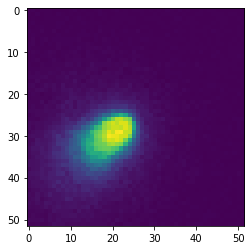

GroundTruth: no-ring
tensor([0])


In [39]:
#Check the ground truth here on test_images
dataiter=iter(testloader)
images, labels=dataiter.next()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:',''.join('%5s'%classes[labels[j]]for j in range(1)))
print(labels)

In [40]:
#load back in our saved model

net=Net_ring_wholedata()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [41]:
##Test the network on the test data:#check if the network has learnt anything at all.
#check this by predicting the class label that the neural network outputs, and checking it
#against the ground-truth we got before:

#now let us see what the neural network thinks these examples above are:
outputs= m(net(images))
predicted = outputs > 0.5
print('Predicted:',' '.join('%5s'%classes[predicted[j]] for j in range(1)))

Predicted:  ring


In [42]:
#Let us look at how the network performs on the whole test_set
correct=0
total=0
test_y=[]
y_score=[]
with torch.no_grad():
    for data in testloader:
        images, labels=data
        outputs=m(net(images))
        predicted=(outputs.data>0.5)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
        y_score.append(outputs.numpy())
        test_y.append(labels)
        #print(outputs.shape)
        
y_score=np.vstack(y_score).flatten()
test_y=np.vstack(test_y).flatten()
print('Accuracy of the network on the test images:%d%%'%(100*correct/total))

Accuracy of the network on the test images:96%


In [43]:
#what are the classes that performed well, and the classes that did not perform well:
class_correct=list(0. for i in range(2))
class_total=list(0. for i in range(2))
with torch.no_grad():
    for data in testloader:
        images, labels=data
        outputs=m(net(images))
        predicted=outputs>0.5
        c=(predicted==labels).squeeze()
        label=labels
        class_correct[label]+=c.item()
        class_total[label]+=1
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i],100*class_correct[i]/class_total[i]))

Accuracy of no-ring : 97 %
Accuracy of  ring : 95 %


In [21]:
import numpy as np 
TP, FP, TN, FN = 0,0,0,0
treshold = 0.95
#for  threshold in np.arange(0.0, 1.0, 0.05):
for data, label in testloader: #with batchsize 1
    predict = m(net(data))
    predict_gamma = 1- predict
    predict_class = predict_gamma > treshold
    #print(predict_class)
    #print(label)
    if label == 1:  
        if predict_class == 1:  #--------------------------FP
            FP+=1
        elif predict_class == 0: #-------------------------------TN-proton
            TN+=1

    elif label == 0:   
        if predict_class == 0: #----------------------FN
            FN+=1
        elif predict_class == 1: #-----------------------------TP-gamma
            TP+=1


print(TP)
print(FP)
print(FN)
print(TN)

0
0
300
360


In [44]:
##Q-factor calculation from single network: gamma/proton
import os 
import glob

tresholds_new = np.arange(0.0, 1, 0.01)
TP_list_new, FP_list_new, TN_list_new, FN_list_new = [],[],[],[]
Q_factor_list_new = []
gamma_efficiency_list_new= []
proton_efficiency_list_new = []
#label_list_new = []
#predict_list_new = []

#get the total number of gammas and protons in the test set of first network(gamma-proton) to calculate the Q factor
total_gammas_new = len(glob.glob('./data/wholedata/without_noise/ring_noring/test_set/gamma/*.npy'))
total_protons_new = len(glob.glob('./data/wholedata/without_noise/ring_noring/test_set/proton/*.npy'))

for treshold_new in tresholds_new:
    ##calculate confusion matrix from the ring-noring network
   
    TP_new, FP_new, FN_new, TN_new = 0, 0, 0, 0
    for data_new, label_new in testloader: #with batchsize 1
        predict_new_proton = m(net(data_new))
        predict_new_gamma = 1-predict_new_proton
        predict_class_new = predict_new_gamma >=  treshold_new
        #predict_class_new = predict_new_proton >  treshold_new
        if label_new == 1:  #-------------------------------FP
            if predict_class_new == 1:
                FP_new+=1
            elif predict_class_new == 0: #---------------------TN-proton
                TN_new+=1

        elif label_new == 0:   #-----------------------------FN
            if predict_class_new == 0:
                FN_new+=1
            elif predict_class_new == 1: #---------------------TP-gamma
                TP_new+=1
        #print(predict_new)
        #print(label_new)
    #label_list_new.append(label_new)
    #predict_list_new.append(predict_new)
    
    TP_list_new.append(TP_new)
    FP_list_new.append(FN_new)
    TN_list_new.append(TN_new)
    FN_list_new.append(FP_new)
    

    ###Qfactor from a single network:
    gamma_efficiency_new = TP_new/(total_gammas_new)
    proton_efficiency_new = FP_new/(total_protons_new)
    gamma_efficiency_list_new.append(gamma_efficiency_new)
    proton_efficiency_list_new.append(proton_efficiency_new)
    Q_factor_new = gamma_efficiency_new/(np.sqrt(proton_efficiency_new))
    Q_factor_list_new.append(Q_factor_new)
    
#print(total_gammas_new)
#print(total_protons_new)
#print(TN_list_new)
#print(FP_list_new)
print(TP_list_new)
#print(FN_list_new)


[300, 297, 297, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 295, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 293, 293, 293, 293, 293, 293, 293, 292, 292, 292, 291, 291, 291, 291, 291, 291, 291, 291, 291, 290, 289, 288, 288, 288, 287, 285, 285, 285, 285, 285, 285, 284, 284, 284, 284, 284, 283, 283, 283, 282, 282, 282, 282, 281, 281, 281, 281, 278, 278, 278, 276, 276, 273, 273, 271, 264, 261, 252, 237]


In [45]:
#predict_list_new

In [46]:
#print(Q_factor_list_new)
print(gamma_efficiency_list_new)
print(proton_efficiency_list_new)
print(len(Q_factor_list_new))
print(len(gamma_efficiency_list_new))
print(len(proton_efficiency_list_new))

[1.0, 0.99, 0.99, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9833333333333333, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.9766666666666667, 0.9766666666666667, 0.9766666666666667, 0.9766666666666667, 0.9766666666666667, 0.9766666666666667, 0.9766666666666667, 0.9733333333333334, 0.9733333333333334, 0.9733333333333334, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.9666666666666667, 0.9633333333333334, 0.96, 0.96, 0.96, 0.9566666666666667, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9433

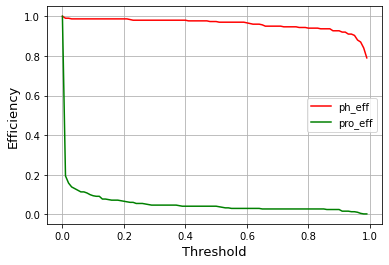

In [47]:
##photon efficiencies vs cut:
plt.plot(tresholds_new, gamma_efficiency_list_new, color='red', label="ph_eff")
##proton efficiency vs cut
plt.plot(tresholds_new, proton_efficiency_list_new, color='green', label='pro_eff')
plt.legend(loc='best')
plt.xlabel("Threshold", fontsize=13)
plt.ylabel("Efficiency", fontsize=13)
plt.grid()

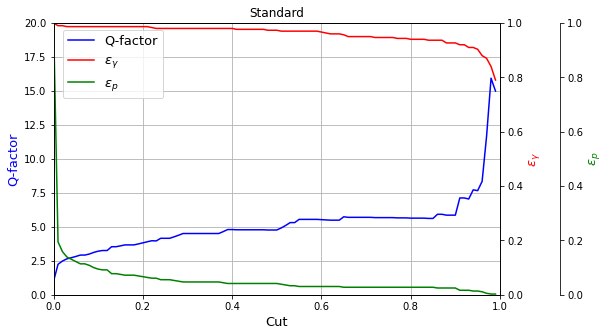

In [49]:
##plotting Q-factor vs cut
# More versatile wrapper
from matplotlib import lines
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0.0, 1)
host.set_ylim(0, 20)
par1.set_ylim(0, 1)
par2.set_ylim(0, 1)
    
host.set_xlabel("Cut", fontsize=13)
host.set_ylabel("Q-factor", fontsize=13)
par1.set_ylabel('$\epsilon_{\gamma}$', fontsize=13)
par2.set_ylabel("$\epsilon_{p}$", fontsize=13)

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

#p1, = host.plot(cut, Q, color='blue', label="Q-factor")
#p2, = par1.plot(cut, eps_gamma, color='red', label=r'$\epsilon_{\gamma}$')
#p3, = par2.plot(cut, eps_proton, color='green', label=r'$\epsilon_{p}$')

p1, = host.plot(tresholds_new, Q_factor_list_new, color='blue', label="Q-factor")
p2, = par1.plot(tresholds_new, gamma_efficiency_list_new, color='red', label=r'$\epsilon_{\gamma}$')
p3, = par2.plot(tresholds_new, proton_efficiency_list_new, color='green', label=r'$\epsilon_{p}$')

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best', bbox_to_anchor=(0.01, 0.5, 0.25, 0.5), fontsize=13)

plt.title('Standard')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))

#tval = 0.86
#host.axvline(tval, color='k', label=f'{tval}')
#host.legend(loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())
host.grid()
# Best for professional typesetting, e.g. LaTeX
#plt.savefig("train_test_blackout_july_22.png", bbox_inches='tight')
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'


In [64]:
np.array(FP_list_new)[tresholds_new==0.86]/total_protons_new
#FP_list_new[np.isclose(tresholds_new, 0.9, atol=0.001)]/n_proto_test

array([0.05555556])

In [65]:
np.array(TP_list_new)[tresholds_new==0.86]/total_gammas_new

array([0.93333333])

In [66]:
#plt.hist(predict_new[label_new==0,1], bins=50, alpha=0.5, label='proton')
#plt.hist(predict_new[label_new==1,1], bins=50, alpha=0.5, label ='gamma')
#plt.yscale('log')
#plt.ylabel('count')
#plt.xlabel('prediction probability')
#plt.legend(loc='best')
#plt.show()

In [ ]:
plt.hist(y_score[test_y==0], bins=20, alpha=0.5, label='gamma')
plt.hist(y_score[test_y==1], bins=20, alpha=0.5, label='proton')
plt.yscale('log', nonposy='clip')
plt.xlabel('probability')
plt.ylabel('counts')
plt.legend(loc='best')
plt.show()

In [ ]:
gamma_efficiency = (class_correct[0]/class_total[0])
proton_efficiency = (FN/TP)
Q_factor = gamma_efficiency/(np.sqrt(proton_efficiency))
#print(gamma_efficiency)
print(Q_factor)

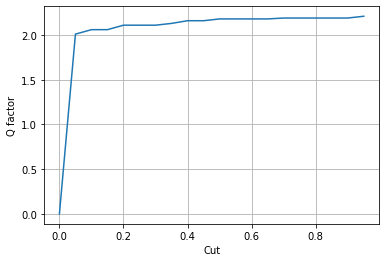

In [91]:
#For 4.5pe noise
cut = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]#, 0.99]
Q =   [0.0, 2.01, 2.06, 2.06, 2.11, 2.11, 2.11, 2.13, 2.16, 2.16, 2.18, 2.18, 2.18, 2.18, 2.19, 2.19, 2.19, 2.19, 2.19, 2.21]#, 6.07 ]
plt.plot(cut, Q)
plt.xlabel('Cut')
plt.ylabel('Q factor')
plt.grid()
plt.show()

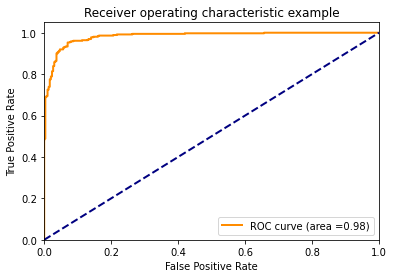

In [212]:
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Compute ROC curve and ROC area for each class
#test_y = labels
#y_score = predicted
fpr, tpr, thresholds=metrics.roc_curve(test_y, y_score)
roc_auc=auc(fpr, tpr)
plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area =%0.2f)'%roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
#print(thresholds)

In [ ]:
#Calculating the confusion matrix(2*2): TP,TN,FP,FN
#print(metrics.confusion_matrix(test_y, y_score.round()))
confusion=metrics.confusion_matrix(test_y, y_score.round())
print(confusion)
#[row, column]
TP=confusion[1,1]
TN=confusion[0,0]
FP=confusion[0,1]
FN=confusion[1,0]

In [ ]:
print(len(y_score))

In [ ]:
np.savetxt('./data/adding_noisy_test_data/y_score_ring.txt', y_score, fmt='%1.4e')   # use exponential notation

In [ ]:
ls

In [ ]:
cd ..

In [ ]:
cd data/

In [ ]:
ls

In [ ]:
cd adding_noisy_test_data/

In [ ]:
#weights,x,y = np.loadtxt('file.txt', unpack=True)
y_score_gp, y_score_rnr = np.loadtxt('combined_y_score.txt', unpack=True)
print(len(y_score_gp))
print(len(y_score_rnr))
plt.scatter(y_score_gp, y_score_rnr)
plt.show()

In [ ]:
cd ..

In [ ]:
cd ..


In [ ]:
ls

In [ ]:
##After adding scattered 10 blackout pixels 
#For noise level: 4.5 pe
import matplotlib.pyplot as plt
import numpy as np

cut = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma = [0.0, 0.64, 0.72, 0.70, 0.71, 0.72, 0.72, 0.78, 0.79, 0.80, 0.82, 0.82, 0.83, 0.84, 0.84, 0.85, 0.86, 0.87, 0.88, 0.90]
eps_proton = [0.0, 0.00097, 0.00097, 0.00097, 0.0019, 0.0019, 0.0029, 0.0029, 0.0038, 0.0058, 0.0058, 0.0058, 0.0067, 0.0067, 0.0077, 0.0077, 0.01, 0.017, 0.020, 0.03]
Q =   [0.0, 21.33, 24, 23.33, 17.75, 18, 14.4, 15.6, 13.16, 11.4, 11.73, 11.82, 10.24, 10.38, 9.65, 9.81, 8.6, 6.69, 6.28, 5.29]
cut_block = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma_block = [0.0, 0.8, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.84, 0.85, 0.85, 0.86, 0.86,  0.86, 0.87, 0.87, 0.87, 0.88]
eps_proton_block = [0.0, 0.02, 0.02, 0.02, 0.02, 0.025, 0.026, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.037, 0.04, 0.04, 0.04, 0.04, 0.05, 0.06]
Q_block =   [0.0, 5.7, 5.52, 5.57, 5.64, 5.33, 5.06, 4.82, 4.88, 4.94, 4.94, 5, 5, 5.05, 4.3, 4.3, 4.35, 4.35, 3.95, 3.66]
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,6)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 1)
host.set_ylim(0, 30)
par1.set_ylim(0, 1)
par2.set_ylim(0, 0.1)
    
host.set_xlabel("Cut", fontsize=13)
host.set_ylabel("Q-factor", fontsize=13)
par1.set_ylabel('$\epsilon_{\gamma}$', fontsize=13)
par2.set_ylabel("$\epsilon_{p}$", fontsize=13)

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

p1, = host.plot(cut, Q, color='blue', label="Q-factor (random)", linestyle='solid')
p2, = par1.plot(cut, eps_gamma, color='blue', label=r'$\epsilon_{\gamma}$ (random)', linestyle='dashed')
p3, = par2.plot(cut, eps_proton, color='blue', label=r'$\epsilon_{p}$ (random)', linestyle='dashdot')

p4, = host.plot(cut_block, Q_block, color='red', label="Q-factor (block)", linestyle='solid')
p5, = par1.plot(cut_block, eps_gamma_block, color='red', label=r'$\epsilon_{\gamma}$ (block)', linestyle='dashed')
p6, = par2.plot(cut_block, eps_proton_block, color='red', label=r'$\epsilon_{p}$ (block)', linestyle='dashdot')

#h, l = plt.get_figlabels()#_legend_handles_labels()
lns = [p1, p2, p3, p4, p5, p6]
plt.legend(handles=lns, ncol=2, bbox_to_anchor=(0.9, 1.35), fontsize=13)

#handles = ph[:1] + h[::2] + ph[1:] + h[1::2]
#labels = ["Random:"] + l[::2] + ["Block:"] + l[1::2]
#leg = plt.legend(handles, labels, ncol=2)


#lns = [p1, p2, p3]#, p4, p5, p6]
#lns1 = [p4, p5, p6]
#host.legend(handles=lns, loc='best', bbox_to_anchor=(0.4, 1.35))
#plt.legend(handles=lns1, loc='lower right', bbox_to_anchor=(0.9, 1.11))

plt.title('Adding 10 blackout pixels (noise: 4.5 p.e)')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))
#plt.legend(loc='center left', bbox_to_anchor=(0.75, 1.1))

host.yaxis.label.set_color(color='k')#(p1.get_color())
par1.yaxis.label.set_color(color='k')#(p2.get_color())
par2.yaxis.label.set_color(color='k')#(p3.get_color())

#plt.yaxis.label.set_color('black')

# Best for professional typesetting, e.g. LaTeX
#plt.savefig("4.5pe_noise.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'
print(np.max(Q))
print(np.max(eps_gamma))
print(np.max(eps_proton))
#plt.tight_layout()
plt.savefig("4.5pe_noise_together.pdf")

In [ ]:
##After adding scattered 10 blackout pixels 
#For noise level: 9 pe
cut = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma = [0.09, 0.86, 0.87, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.90, 0.91, 0.91, 0.92, 0.93, 0.94, 0.94, 0.95, 0.95, 0.96, 0.96]
eps_proton = [0.01, 0.49, 0.51, 0.52, 0.52, 0.52, 0.52, 0.53, 0.54, 0.55, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.60, 0.62, 0.63, 0.65]
Q =   [0.9, 1.75, 1.22, 1.22, 1.22, 1.22, 1.23, 1.23, 1.21, 1.21, 1.22, 1.22, 1.22, 1.22, 1.23, 1.22, 1.23, 1.21, 1.21, 1.2]

cut_block = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma_block = [0.006, 0.89, 0.90, 0.91, 0.91, 0.92, 0.92, 0.93, 0.93, 0.93, 0.93, 0.94, 0.94, 0.94, 0.94, 0.94, 0.95, 0.95, 0.95, 0.96]
eps_proton_block = [0.0019, 0.50, 0.53, 0.54, 0.55, 0.56, 0.57, 0.57, 0.58, 0.57, 0.58, 0.59, 0.59, 0.59, 0.60, 0.61, 0.61, 0.62, 0.63, 0.64]
Q_block =   [0.15, 1.27, 1.25, 1.24, 1.22, 1.24, 1.22, 1.24, 1.22, 1.24, 1.22, 1.23, 1.34, 1.23, 1.22, 1.20, 1.21, 1.21, 1.20, 1.2]
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,6)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 1)
host.set_ylim(0, 30)
par1.set_ylim(0, 1)
par2.set_ylim(0, 1)
    
host.set_xlabel("Cut", fontsize=13)
host.set_ylabel("Q-factor", fontsize=13)
par1.set_ylabel('$\epsilon_{\gamma}$', fontsize=13)
par2.set_ylabel("$\epsilon_{p}$", fontsize=13)

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

p1, = host.plot(cut, Q, color='blue', label="Q-factor (random)", linestyle='solid')
p2, = par1.plot(cut, eps_gamma, color='blue', label=r'$\epsilon_{\gamma}$ (random)', linestyle='dashed')
p3, = par2.plot(cut, eps_proton, color='blue', label=r'$\epsilon_{p}$ (random)', linestyle='dashdot')

p4, = host.plot(cut_block, Q_block, color='red', label="Q-factor (block)", linestyle='solid')
p5, = par1.plot(cut_block, eps_gamma_block, color='red', label=r'$\epsilon_{\gamma}$ (block)', linestyle='dashed')
p6, = par2.plot(cut_block, eps_proton_block, color='red', label=r'$\epsilon_{p}$ (block)', linestyle='dashdot')

#h, l = plt.get_figlabels()#_legend_handles_labels()
lns = [p1, p2, p3, p4, p5, p6]
plt.legend(handles=lns, ncol=2, bbox_to_anchor=(0.9, 1.35), fontsize=13)

#handles = ph[:1] + h[::2] + ph[1:] + h[1::2]
#labels = ["Random:"] + l[::2] + ["Block:"] + l[1::2]
#leg = plt.legend(handles, labels, ncol=2)


#lns = [p1, p2, p3]#, p4, p5, p6]
#lns1 = [p4, p5, p6]
#host.legend(handles=lns, loc='best', bbox_to_anchor=(0.4, 1.35))
#plt.legend(handles=lns1, loc='lower right', bbox_to_anchor=(0.9, 1.11))

plt.title('Adding 10 blackout pixels (noise: 9 p.e)')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))
#plt.legend(loc='center left', bbox_to_anchor=(0.75, 1.1))

host.yaxis.label.set_color(color='k')#(p1.get_color())
par1.yaxis.label.set_color(color='k')#(p2.get_color())
par2.yaxis.label.set_color(color='k')#(p3.get_color())

#plt.yaxis.label.set_color('black')

# Best for professional typesetting, e.g. LaTeX
#plt.savefig("4.5pe_noise.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'
print(np.max(Q))
print(np.max(eps_gamma))
print(np.max(eps_proton))
#plt.tight_layout()
#plt.savefig("9pe_noise_together.pdf")

In [ ]:
##After adding scattered 10 blackout pixels 
#For noise level: 9 pe
cut = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma = [0, 0.52, 0.6, 0.649, 0.66, 0.69, 0.72, 0.74, 0.77, 0.78, 0.80, 0.81, 0.88, 0.89, 0.90, 0.91, 0.92, 0.93, 0.94, 0.96]
eps_proton = [0, 0.00097, 0.00097, 0.00097, 0.00097, 0.00097, 0.00097, 0.00097, 0.00097, 0.0038, 0.0048, 0.0048, 0.018, 0.019, 0.023, 0.025, 0.028, 0.033, 0.03, 0.048]
Q = [0, 16.77, 19.35, 20.93, 21.29, 22.53, 23.22, 24.11, 24.91, 12.78, 11.54, 11.69, 6.55, 6.45, 5.93, 5.75, 5.49, 5.11, 5.42, 4.38]

cut_block = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma_block = [0, 0.69, 0.74, 0.77, 0.8, 0.81, 0.82, 0.83, 0.84, 0.86, 0.86, 0.87, 0.88, 0.88, 0.90, 0.91, 0.92, 0.92,  0.94, 0.94]
eps_proton_block = [0, 0.51, 0.53, 0.55, 0.57, 0.58, 0.59, 0.60, 0.60, 0.61, 0.61, 0.62, 0.63, 0.64, 0.64, 0.65, 0.66, 0.68, 0.7, 0.72]
Q_block = [0, 0.97, 1.02, 1.04, 1.06, 1.06, 1.07, 1.07, 1.09, 1.10, 1.11, 1.11, 1.11, 1.1, 1.12, 1.01, 1.13, 1.12,1.13, 1.11]

# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,6)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 1)
host.set_ylim(0, 30)
par1.set_ylim(0, 1)
par2.set_ylim(0, 1)
    
host.set_xlabel("Cut", fontsize=13)
host.set_ylabel("Q-factor", fontsize=13)
par1.set_ylabel('$\epsilon_{\gamma}$', fontsize=13)
par2.set_ylabel("$\epsilon_{p}$", fontsize=13)

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

p1, = host.plot(cut, Q, color='blue', label="Q-factor (random)", linestyle='solid')
p2, = par1.plot(cut, eps_gamma, color='blue', label=r'$\epsilon_{\gamma}$ (random)', linestyle='dashed')
p3, = par2.plot(cut, eps_proton, color='blue', label=r'$\epsilon_{p}$ (random)', linestyle='dashdot')

p4, = host.plot(cut_block, Q_block, color='red', label="Q-factor (block)", linestyle='solid')
p5, = par1.plot(cut_block, eps_gamma_block, color='red', label=r'$\epsilon_{\gamma}$ (block)', linestyle='dashed')
p6, = par2.plot(cut_block, eps_proton_block, color='red', label=r'$\epsilon_{p}$ (block)', linestyle='dashdot')

#h, l = plt.get_figlabels()#_legend_handles_labels()
lns = [p1, p2, p3, p4, p5, p6]
plt.legend(handles=lns, ncol=2, bbox_to_anchor=(0.9, 1.35), fontsize=13)

#handles = ph[:1] + h[::2] + ph[1:] + h[1::2]
#labels = ["Random:"] + l[::2] + ["Block:"] + l[1::2]
#leg = plt.legend(handles, labels, ncol=2)


#lns = [p1, p2, p3]#, p4, p5, p6]
#lns1 = [p4, p5, p6]
#host.legend(handles=lns, loc='best', bbox_to_anchor=(0.4, 1.35))
#plt.legend(handles=lns1, loc='lower right', bbox_to_anchor=(0.9, 1.11))

plt.title('Adding 10 blackout pixels (noise: 9 p.e)')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))
#plt.legend(loc='center left', bbox_to_anchor=(0.75, 1.1))

host.yaxis.label.set_color(color='k')#(p1.get_color())
par1.yaxis.label.set_color(color='k')#(p2.get_color())
par2.yaxis.label.set_color(color='k')#(p3.get_color())

#plt.yaxis.label.set_color('black')

# Best for professional typesetting, e.g. LaTeX
#plt.savefig("4.5pe_noise.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'
print(np.max(Q))
print(np.max(eps_gamma))
print(np.max(eps_proton))
#plt.tight_layout()
plt.savefig("9pe_noise_together.pdf")

In [ ]:
##After adding scattered 10 blackout pixels 
#For noise level: 20 pe
cut = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma = [0.0, 0.62, 0.68, 0.70, 0.71, 0.75, 0.75, 0.77, 0.78, 0.78, 0.80, 0.81, 0.81, 0.82, 0.82,  0.82, 0.83, 0.84, 0.85, 0.87]
eps_proton = [0.0,0.0019, 0.0029, 0.0038, 0.0038, 0.0058, 0.0058, 0.0077, 0.0087, 0.0097, 0.0097, 0.01, 0.01, 0.01, 0.017, 0.01, 0.019, 0.021, 0.027, 0.037]
Q =   [0.0, 15.5, 13.6, 11.66, 11.83, 10.71, 10.71, 9.62, 8.66, 7.95, 8.16, 8.1, 8.1,8.2, 6.38, 6.38, 6.38, 6, 5.3, 4.57]

##After adding 10 block of blackout pixels 
#For noise level: 20 pe
cut_block = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma_block = [0.0, 0.82, 0.86, 0.87, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.90, 0.91, 0.91, 0.92, 0.92, 0.93, 0.94]
eps_proton_block = [0.0, 0.27, 0.29, 0.29, 0.30, 0.30, 0.31, 0.31, 0.31, 0.32, 0.32, 0.33, 0.33, 0.34, 0.34, 0.35, 0.36, 0.37, 0.38, 0.40]
Q_block =   [0.0, 1.60, 1.62, 1.64, 1.61, 1.62, 1.6, 1.6, 1.6, 1.57, 1.58, 1.56, 1.56, 1.55, 1.56, 1.53, 1.53, 1.51, 1.50, 1.48]
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,6)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 1)
host.set_ylim(0, 30)
par1.set_ylim(0, 1)
par2.set_ylim(0, 1)
    
host.set_xlabel("Cut", fontsize=13)
host.set_ylabel("Q-factor", fontsize=13)
par1.set_ylabel('$\epsilon_{\gamma}$', fontsize=13)
par2.set_ylabel("$\epsilon_{p}$", fontsize=13)

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

p1, = host.plot(cut, Q, color='blue', label="Q-factor (random)", linestyle='solid')
p2, = par1.plot(cut, eps_gamma, color='blue', label=r'$\epsilon_{\gamma}$ (random)', linestyle='dashed')
p3, = par2.plot(cut, eps_proton, color='blue', label=r'$\epsilon_{p}$ (random)', linestyle='dashdot')

p4, = host.plot(cut_block, Q_block, color='red', label="Q-factor (block)", linestyle='solid')
p5, = par1.plot(cut_block, eps_gamma_block, color='red', label=r'$\epsilon_{\gamma}$ (block)', linestyle='dashed')
p6, = par2.plot(cut_block, eps_proton_block, color='red', label=r'$\epsilon_{p}$ (block)', linestyle='dashdot')

#h, l = plt.get_figlabels()#_legend_handles_labels()
lns = [p1, p2, p3, p4, p5, p6]
plt.legend(handles=lns, ncol=2, bbox_to_anchor=(0.9, 1.35), fontsize=13)

#handles = ph[:1] + h[::2] + ph[1:] + h[1::2]
#labels = ["Random:"] + l[::2] + ["Block:"] + l[1::2]
#leg = plt.legend(handles, labels, ncol=2)


#lns = [p1, p2, p3]#, p4, p5, p6]
#lns1 = [p4, p5, p6]
#host.legend(handles=lns, loc='best', bbox_to_anchor=(0.4, 1.35))
#plt.legend(handles=lns1, loc='lower right', bbox_to_anchor=(0.9, 1.11))

plt.title('Adding 10 blackout pixels (noise: 20 p.e)')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))
#plt.legend(loc='center left', bbox_to_anchor=(0.75, 1.1))

host.yaxis.label.set_color(color='k')#(p1.get_color())
par1.yaxis.label.set_color(color='k')#(p2.get_color())
par2.yaxis.label.set_color(color='k')#(p3.get_color())

#plt.yaxis.label.set_color('black')

# Best for professional typesetting, e.g. LaTeX
#plt.savefig("4.5pe_noise.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'
print(np.max(Q))
print(np.max(eps_gamma))
print(np.max(eps_proton))
#plt.tight_layout()
plt.savefig("20pe_noise_together.pdf")

In [ ]:
##After adding scattered 10 blackout pixels 
#For noise level: 40 pe
cut = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma = [0, 0.65, 0.7, 0.72, 0.74, 0.76, 0.77, 0.78, 0.78, 0.79, 0.80, 0.80, 0.81, 0.82, 0.83, 0.83, 0.84, 0.86, 0.87, 0.90]
eps_proton = [0, 0.0048, 0.0087, 0.0087, 0.01, 0.01, 0.011, 0.01, 0.01, 0.016, 0.017, 0.021, 0.025, 0.028, 0.030, 0.033, 0.037, 0.04, 0.05, 0.072]
Q =  [0, 9.42, 7.77, 8, 7.4, 7.6, 7.7, 7.8, 7.8, 6.24, 6.13, 5.52, 5.12, 5.12, 4.88, 4.56, 4.36, 4.3, 3.89, 3.46]

##After adding 10 block of blackout pixels 
#For noise level: 40 pe
cut_block = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma_block = [0, 0.82, 0.85, 0.86, 0.87, 0.87, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.89, 0.90, 0.90, 0.91, 0.91, 0.92, 0.92, 0.93]
eps_proton_block = [0, 0.39, 0.41, 0.42, 0.42, 0.42, 0.43, 0.43, 0.43, 0.44, 0.44, 0.44, 0.45, 0.45, 0.45, 0.46, 0.46, 0.47, 0.48, 0.50]
Q_block = [0, 1.31, 1.32, 1.32, 1.34, 1.34, 1.34, 1.34, 1.34, 1.34, 1.34, 1.34, 1.32, 1.34, 1.34, 1.34, 1.34, 1.34, 1.32, 1.31]
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,6)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 1)
host.set_ylim(0, 30)
par1.set_ylim(0, 1)
par2.set_ylim(0, 1)
    
host.set_xlabel("Cut", fontsize=13)
host.set_ylabel("Q-factor", fontsize=13)
par1.set_ylabel('$\epsilon_{\gamma}$', fontsize=13)
par2.set_ylabel("$\epsilon_{p}$", fontsize=13)

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

p1, = host.plot(cut, Q, color='blue', label="Q-factor (random)", linestyle='solid')
p2, = par1.plot(cut, eps_gamma, color='blue', label=r'$\epsilon_{\gamma}$ (random)', linestyle='dashed')
p3, = par2.plot(cut, eps_proton, color='blue', label=r'$\epsilon_{p}$ (random)', linestyle='dashdot')

p4, = host.plot(cut_block, Q_block, color='red', label="Q-factor (block)", linestyle='solid')
p5, = par1.plot(cut_block, eps_gamma_block, color='red', label=r'$\epsilon_{\gamma}$ (block)', linestyle='dashed')
p6, = par2.plot(cut_block, eps_proton_block, color='red', label=r'$\epsilon_{p}$ (block)', linestyle='dashdot')

#h, l = plt.get_figlabels()#_legend_handles_labels()
lns = [p1, p2, p3, p4, p5, p6]
plt.legend(handles=lns, ncol=2, bbox_to_anchor=(0.9, 1.35), fontsize=13)

#handles = ph[:1] + h[::2] + ph[1:] + h[1::2]
#labels = ["Random:"] + l[::2] + ["Block:"] + l[1::2]
#leg = plt.legend(handles, labels, ncol=2)


#lns = [p1, p2, p3]#, p4, p5, p6]
#lns1 = [p4, p5, p6]
#host.legend(handles=lns, loc='best', bbox_to_anchor=(0.4, 1.35))
#plt.legend(handles=lns1, loc='lower right', bbox_to_anchor=(0.9, 1.11))

plt.title('Adding 10 blackout pixels (noise: 40 p.e)')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))
#plt.legend(loc='center left', bbox_to_anchor=(0.75, 1.1))

host.yaxis.label.set_color(color='k')#(p1.get_color())
par1.yaxis.label.set_color(color='k')#(p2.get_color())
par2.yaxis.label.set_color(color='k')#(p3.get_color())

#plt.yaxis.label.set_color('black')

# Best for professional typesetting, e.g. LaTeX
#plt.savefig("4.5pe_noise.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'
print(np.max(Q))
print(np.max(eps_gamma))
print(np.max(eps_proton))
#plt.tight_layout()
plt.savefig("40pe_noise_together.pdf")

In [ ]:
##After adding scattered 10 blackout pixels 
#For noise level: 20 pe
cut = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma = [0.0, 0.62, 0.68, 0.70, 0.71, 0.75, 0.75, 0.77, 0.78, 0.78, 0.80, 0.81, 0.81, 0.82, 0.82,  0.82, 0.83, 0.84, 0.85, 0.87]
eps_proton = [0.0,0.0019, 0.0029, 0.0038, 0.0038, 0.0058, 0.0058, 0.0077, 0.0087, 0.0097, 0.0097, 0.01, 0.01, 0.01, 0.017, 0.01, 0.019, 0.021, 0.027, 0.037]
Q =   [0.0, 15.5, 13.6, 11.66, 11.83, 10.71, 10.71, 9.62, 8.66, 7.95, 8.16, 8.1, 8.1,8.2, 6.38, 6.38, 6.38, 6, 5.3, 4.57]

##After adding 10 block of blackout pixels 
#For noise level: 20 pe
cut_block = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma_block = [0.0, 0.82, 0.86, 0.87, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.90, 0.91, 0.91, 0.92, 0.92, 0.93, 0.94]
eps_proton_block = [0.0, 0.27, 0.29, 0.29, 0.30, 0.30, 0.31, 0.31, 0.31, 0.32, 0.32, 0.33, 0.33, 0.34, 0.34, 0.35, 0.36, 0.37, 0.38, 0.40]
Q_block =   [0.0, 1.60, 1.62, 1.64, 1.61, 1.62, 1.6, 1.6, 1.6, 1.57, 1.58, 1.56, 1.56, 1.55, 1.56, 1.53, 1.53, 1.51, 1.50, 1.48]
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 1)
host.set_ylim(0, 30)
par1.set_ylim(0, 1)
par2.set_ylim(0, 0.5)
    
host.set_xlabel("Cut")
host.set_ylabel("Q-factor")
par1.set_ylabel('$\epsilon_{\gamma}$')
par2.set_ylabel("$\epsilon_{p}$")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

p1, = host.plot(cut, Q, color='blue', label="Q-factor(random)")
p2, = par1.plot(cut, eps_gamma, color='red', label=r'$\epsilon_{\gamma}$(random)')
p3, = par2.plot(cut, eps_proton, color='green', label=r'$\epsilon_{p}$(random)')

p4, = host.plot(cut_block, Q_block, color='blue', label="Q-factor(block)", linestyle='dashed')
p5, = par1.plot(cut_block, eps_gamma_block, color='red', label=r'$\epsilon_{\gamma}$(block)', linestyle='dashed')
p6, = par2.plot(cut_block, eps_proton_block, color='green', label=r'$\epsilon_{p}$(block)', linestyle='dashed')



lns = [p1, p2, p3, p4, p5, p6]
host.legend(handles=lns, loc='best')

plt.title('Adding blackout pixels (noise: 20 p.e)')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

# Best for professional typesetting, e.g. LaTeX
#plt.savefig("4.5pe_noise.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'
print(np.max(Q_block))
print(np.max(eps_gamma_block))
print(np.max(eps_proton_block))